![Py4Eng](../logo.png)

# Finetuning pretrained model 
## Yoav Ram

This notebook shows a step-by-step finetuning workflow using a pretrained [EfficientNetV2](https://arxiv.org/pdf/2104.00298) backbone (from `timm`) and PyTorch. The target dataset is the [Hyena ID 2022](https://lila.science/datasets/hyena-id-2022/) dataset (3104 photos, 256 individuals).
The task is viewpoint prediction - classifying the viewpoint on the hyena in the images.

In [ ]:
%matplotlib inline
import os
import shutil
from collections import Counter
import tarfile
import urllib.request
import random
from tqdm import tqdm
from pathlib import Path
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from pytorch_metric_learning.losses import ArcFaceLoss

print('torch', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
num_workers = 8 if torch.cuda.is_available() else 0
print('Device:', device)

# --- training configuration toggles ---
use_weighted_sampler = True          # set True to use WeightedRandomSampler to balance batches
use_class_weights = False           # set True to use class-weighted CrossEntropy instead of sampler (don't use both)
label_smoothing = 0.0               # set >0 to enable label smoothing (e.g. 0.1)

/home/jupyter-yoavram/miniforge3/envs/DataSciPy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch 2.7.1
Device: cuda


# Data

We Download the [Hyena ID 2022 dataset](https://lila.science/datasets/hyena-id-2022/) and extract to `data/hyena`. 

In [2]:
url = "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/wild-me/hyena.coco.tar.gz"
out_path = '../data/hyena.coco.tar.gz'
extract_dir = '../data/hyena'
chunk = 1024 * 1024

os.makedirs(os.path.dirname(out_path), exist_ok=True)

In [3]:
if not os.path.exists(extract_dir):
    if not os.path.exists(out_path):
        print(f'Downloading {url} to {out_path}')
        with urllib.request.urlopen(url) as r, open(out_path, 'wb') as f:
            total = r.getheader('Content-Length')
            total = int(total) if total else None
            with tqdm(total=total, unit='B', unit_scale=True, desc='download') as p:
                while True:
                    data = r.read(chunk)
                    if not data:
                        break
                    f.write(data)
                    p.update(len(data))
    else:
        print(f'File {out_path} already exists, skipping download.')

    print(f"Extracting {out_path}")
    with tarfile.open(out_path, 'r:gz') as t:
        os.makedirs(extract_dir, exist_ok=True)
        t.extractall(path=extract_dir)
else:
    print(f'Extraction directory already exists, skipping extraction.')

Extraction directory already exists, skipping extraction.



The metadata is in `../data/hyena/hyena.coco/annotations/instances_train2022.json`, which contains the bounding box of the individuals in the images, as well as their the viewpoints.

Load COCO-style annotations and build mapping from filename to bbox and to viewpoint.

In [4]:
with open('../data/hyena/hyena.coco/annotations/instances_train2022.json', 'r') as f:
    metadata = json.load(f)
bboxes = {a['image_id']: a['bbox'] for a in metadata['annotations']}
viewpoints = {a['image_id']: a['viewpoint'] for a in metadata['annotations']}

All the hyena images are now in `../data/hyena/hyena.coco/images/train2022` folder (`test2022` and `val2022` are empty). Image filenames are just the image running number.

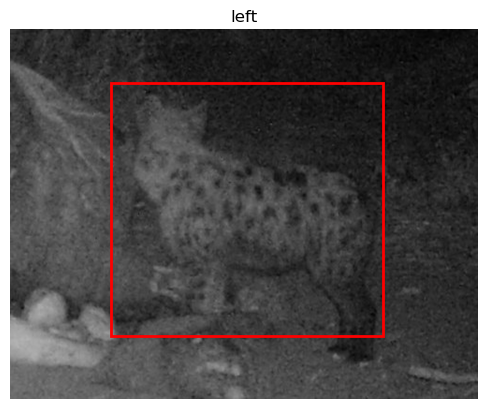

In [5]:
path_template = '../data/hyena/hyena.coco/images/train2022/{:012d}.jpg'

def plot_image(image_id, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    path = path_template.format(image_id)
    image = Image.open(path)    
    ax.imshow(image)
    bbox = bboxes[image_id]
    viewpoint = viewpoints[image_id]
    x, y, w, h = bbox  # Top-Left X, Top-Left Y, Width, Height
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', lw=2)
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title(viewpoint)
    return ax

plot_image(np.random.randint(1, len(bboxes)+1));

Now we get the labels -- the viewpoints.

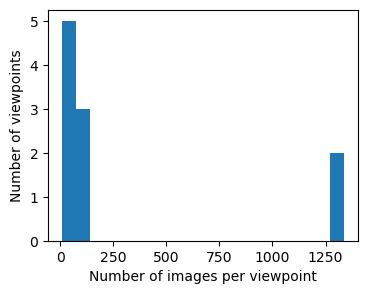

In [6]:
img_ids = np.array(list(viewpoints.keys()))

counter = Counter(viewpoints.values())
plt.figure(figsize=(4, 3))
plt.hist(counter.values(), 20)
plt.xlabel('Number of images per viewpoint');
plt.ylabel('Number of viewpoints');

This histogram is very skewed because most viewpoints are either right or left.

Map viewpoints to integers and back.

In [7]:
view2id = {k:i for i,k in enumerate(counter.keys())}
int2view = {i:k for k,i in view2id.items()}
labels = np.array([view2id[viewpoints[img]] for img in img_ids])
n_classes = int(labels.max() + 1)
print("Number of classes:", n_classes)

Number of classes: 10


Split to train and test sets by defining the indexes that go to either set.
We use a stratified split so each viewpoint is represented in train and val

In [8]:
rng = np.random.default_rng(23)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=23)
train_idx, val_idx = next(sss.split(img_ids, labels))
print("Number of train samples {}\nNumber of validation samples {}".format(len(train_idx), len(val_idx)))

Number of train samples 2793
Number of validation samples 311


We now define a dataset class that takes image identifiers and their corresponding labels and on each iteration loads and returns an image and its label. Images are cropped to the bounding boxes (red box on image above) and transformed with whatever transformers are given to the `HyenaDataset` object.

In [9]:
class HyenaDataset(Dataset):    
    def __init__(self, img_ids, labels, transform=None):
        assert len(img_ids) == len(labels)
        self.img_ids = img_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        image_id = self.img_ids[idx]
        label = self.labels[idx]
        path = path_template.format(image_id)
        image = Image.open(path).convert('RGB')
        # crop to bbox
        bbox = bboxes[image_id]
        x, y, w, h = bbox
        image = image.crop((x, y, x + w, y + h))
        # apply transforms
        if self.transform:
            image = self.transform(image)
        return image, label

Definte the image transforms.
For the validation set, we just resize the image to the size suitable for the model, convert to PyTorch tensor, and normalize colors.

For the training transforms, we also augment the data using cropping, rotations, color jitters, and even random erasing. 
Note that we do not perform horizontal flips as those will mess up the viewpoint!

For more details on augmentations, see [Mumuni & Mumuni, 2022](https://www.sciencedirect.com/science/article/pii/S2590005622000911)

In [12]:
img_size = 224

val_transforms = T.Compose([
    T.Resize((img_size, img_size)),    
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

train_transforms = T.Compose([
    T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

Now we create the datasets and data loaders.

In [13]:
batch_size = 64

train_ds = HyenaDataset(img_ids=img_ids[train_idx], labels=labels[train_idx], transform=train_transforms)
val_ds = HyenaDataset(img_ids=img_ids[val_idx], labels=labels[val_idx], transform=val_transforms)

# Create a non-augmented train dataset/loader for stable train-accuracy evaluation (no augmentation)
train_eval_ds = HyenaDataset(img_ids=img_ids[train_idx], labels=labels[train_idx], transform=val_transforms)
train_eval_loader = DataLoader(train_eval_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Create a WeightedRandomSampler so batches are class-balanced (helps with skewed viewpoint distribution)
from torch.utils.data import WeightedRandomSampler
counts = np.bincount(labels[train_idx], minlength=n_classes)

if use_weighted_sampler:
    # sample weights inverse to class frequency
    class_weights_for_sampling = 1.0 / (counts + 1e-6)
    sample_weights = class_weights_for_sampling[labels[train_idx]]
    sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.float),
                                     num_samples=len(sample_weights),
                                     replacement=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
else:
    sampler = None
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Here's how the images look like coming out of the dataset object.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.8556864].


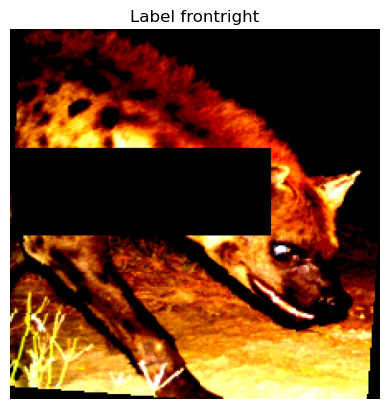

In [15]:
img, lbl = train_ds[np.random.randint(len(train_ds))]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Label {int2view[lbl]}');

## Model
Load a pretrained **EfficientNetV2_s** without the classifier head. We use the small variant `_s` for speed; change to `_m` or `_l` if you want better performance.
See [model card](https://huggingface.co/timm/tf_efficientnetv2_s.in21k_ft_in1k) for details.

We set `num_classes` so the model is loaded with a new classifier head with just 10 classes.

In [16]:
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True, 
    num_classes=n_classes
)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

Let's see the model in action. Because we specificed `num_classes=10`, the outputs are the logits of the classification head. To get proper probabilities ($\hat{y}$) we would need to use `softmax`, but we don't really need the probabilities.

In [17]:
logits = model(img.unsqueeze(0))
print("Logits shape:", logits.shape)
print(logits)

Logits shape: torch.Size([1, 10])
tensor([[-2.6814, -3.7434, -2.8922, -0.3548,  0.2540, -1.9596, -0.5759,  0.5380,
         -0.2705,  0.4298]], grad_fn=<AddmmBackward0>)


### Freeze backbone and train classifier head
We freeze all parameters except the classifier parameters.

In [18]:
# Freeze backbone
for p in model.parameters():
    p.requires_grad = False
# Unfreeze classifier head
for p in model.get_classifier().parameters():
    p.requires_grad = True

Define an optimizer for the model parameters. Use *AdamW* with small weight decay to reduce overfitting.

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

We define the cross entropy loss function with class-weights to combat the class imbalance in the dataset.

In [20]:
counts = np.bincount(labels[train_idx], minlength=n_classes)
if use_class_weights:
    # class weighting for CrossEntropy (choose this OR use_weighted_sampler, not both)
    class_weights = 1.0 / (counts + 1e-6)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)
else:
    loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

Define a function to train the model for one epoch and another function to evaluate it at the end of the epoch.

In [21]:
def train(model, loss_fn, data_loader, optimizer):
    model.train()
    running_loss = 0.0 # for the entire epoch
    pbar = tqdm(data_loader, desc='Training', unit='batch')
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        pbar.set_postfix({'loss': f'{loss:.4f}'})
    return running_loss / len(data_loader.dataset)

In [22]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total if total else 0.0

Now let's train just the classifier head (the backbone is frozen) for several epochs.
We first move the model and loss function to the accelerator device.

In [23]:
model.to(device)
loss_fn = loss_fn.to(device)

val_acc = []
train_acc = []
n_epochs = 5
epoch = 0

# Evaluate initial train/val. Use the non-augmented train-eval loader for train accuracy if available so metrics are comparable.
train_acc.append(evaluate(model, train_eval_loader))
val_acc.append(evaluate(model, val_loader))
print(f'Before training: train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer)
    train_acc.append(evaluate(model, train_eval_loader))    
    val_acc.append(evaluate(model, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
    epoch += 1

Before training: train acc 0.0304 | val acc 0.0257


Training: 100%|██████████| 44/44 [00:12<00:00,  3.65batch/s, loss=6.9112]



Epoch 1/5: loss 7.4321 | train acc 0.0422 | val acc 0.0579


Training: 100%|██████████| 44/44 [00:12<00:00,  3.63batch/s, loss=6.5382]



Epoch 2/5: loss 6.9503 | train acc 0.0548 | val acc 0.0547


Training: 100%|██████████| 44/44 [00:12<00:00,  3.60batch/s, loss=6.8085]



Epoch 3/5: loss 6.6776 | train acc 0.0702 | val acc 0.0707


Training: 100%|██████████| 44/44 [00:12<00:00,  3.59batch/s, loss=7.4323]



Epoch 4/5: loss 6.4960 | train acc 0.0795 | val acc 0.0868


Training: 100%|██████████| 44/44 [00:11<00:00,  3.67batch/s, loss=6.4508]



Epoch 5/5: loss 6.1810 | train acc 0.0841 | val acc 0.0804


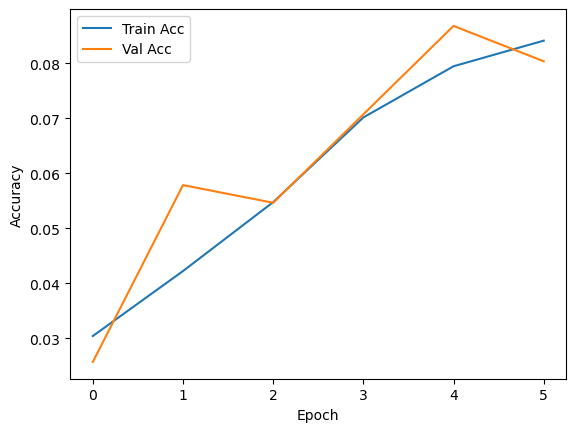

In [24]:
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

### Unfreeze and finetune the whole model
Now we unfreeze all parameters and create a new optimizer with a lower learning rate for the backbone parameters.

We also define a scheduler for the optimizer so the learning rate is reduced when the loss plateaus.

In [25]:
for p in model.parameters():
    p.requires_grad = True

# Use discriminative learning rates: lower for backbone, higher for classifier head
# Only include parameters that require gradients (avoid accidentally adding frozen params)
classifier_params = [p for p in model.get_classifier().parameters() if p.requires_grad]
backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and 'classifier' not in n]
optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': classifier_params, 'lr': 1e-4}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

Now continue training the entire model (backbone+head).
This typically improves performance but takes longer as we have many more parameters.

In [26]:
print(f'Before training: val_acc {val_acc[-1]:.4f}')

# Early stopping for full finetune
n_epochs = 100
best_val_full = val_acc[-1]
best_model_wts_full = model.state_dict()
patience_full = 10
no_improve_full = 0

while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer)
    train_acc.append(evaluate(model, train_eval_loader))
    val_acc.append(evaluate(model, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train_acc {train_acc[-1]:.4f} | val_acc {val_acc[-1]:.4f}')
    scheduler.step(val_acc[-1]) # note the scheduler step is after validation
    # Early stopping logic
    if val_acc[-1] > best_val_full + 1e-5:
        best_val_full = val_acc[-1]
        best_model_wts_full = model.state_dict()
        no_improve_full = 0
    else:
        no_improve_full += 1
    if no_improve_full >= patience_full:
        print(f'No improvement for {patience_full} epochs. Early stopping full finetune.')
        break
    epoch += 1

# restore best full-finetune weights
model.load_state_dict(best_model_wts_full)

Before training: val_acc 0.0804


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=4.3775]



Epoch 6/100: loss 4.8943 | train_acc 0.1368 | val_acc 0.1190


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=2.9626]



Epoch 7/100: loss 3.3212 | train_acc 0.2005 | val_acc 0.1768


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=2.2877]



Epoch 8/100: loss 2.7119 | train_acc 0.2657 | val_acc 0.2347


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=2.5417]



Epoch 9/100: loss 2.0206 | train_acc 0.3233 | val_acc 0.2669


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=1.7598]



Epoch 10/100: loss 1.7436 | train_acc 0.3659 | val_acc 0.2926


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=1.1979]



Epoch 11/100: loss 1.3710 | train_acc 0.4146 | val_acc 0.3151


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=1.6012]



Epoch 12/100: loss 1.2078 | train_acc 0.4561 | val_acc 0.3537


Training: 100%|██████████| 44/44 [00:16<00:00,  2.75batch/s, loss=1.0050]



Epoch 13/100: loss 1.0713 | train_acc 0.4744 | val_acc 0.3537


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=1.0339]



Epoch 14/100: loss 0.9833 | train_acc 0.5134 | val_acc 0.3987


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.9024]



Epoch 15/100: loss 0.8790 | train_acc 0.5403 | val_acc 0.4116


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.8690]



Epoch 16/100: loss 0.7146 | train_acc 0.5754 | val_acc 0.4148


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.4281]



Epoch 17/100: loss 0.6695 | train_acc 0.5990 | val_acc 0.4373


Training: 100%|██████████| 44/44 [00:16<00:00,  2.75batch/s, loss=0.3977]



Epoch 18/100: loss 0.5961 | train_acc 0.6183 | val_acc 0.4405


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.3569]



Epoch 19/100: loss 0.6246 | train_acc 0.6423 | val_acc 0.4791


Training: 100%|██████████| 44/44 [00:15<00:00,  2.76batch/s, loss=1.3342]


Epoch 20/100: loss 0.5444 | train_acc 0.6674 | val_acc 0.5080


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.4754]



Epoch 21/100: loss 0.4574 | train_acc 0.6892 | val_acc 0.5177


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.4064]



Epoch 22/100: loss 0.4404 | train_acc 0.7000 | val_acc 0.5145


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.6552]



Epoch 23/100: loss 0.3988 | train_acc 0.7304 | val_acc 0.5466


Training: 100%|██████████| 44/44 [00:15<00:00,  2.75batch/s, loss=0.8864]


Epoch 24/100: loss 0.4119 | train_acc 0.7340 | val_acc 0.5402


Training: 100%|██████████| 44/44 [00:16<00:00,  2.69batch/s, loss=0.1938]



Epoch 25/100: loss 0.3412 | train_acc 0.7551 | val_acc 0.5595


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.4132]



Epoch 26/100: loss 0.3438 | train_acc 0.7716 | val_acc 0.5788


Training: 100%|██████████| 44/44 [00:16<00:00,  2.70batch/s, loss=0.0743]



Epoch 27/100: loss 0.3250 | train_acc 0.7805 | val_acc 0.5949


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.3656]



Epoch 28/100: loss 0.2863 | train_acc 0.7895 | val_acc 0.5788


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.3108]



Epoch 29/100: loss 0.2725 | train_acc 0.8049 | val_acc 0.5916


Training: 100%|██████████| 44/44 [00:16<00:00,  2.75batch/s, loss=0.5180]



Epoch 30/100: loss 0.2450 | train_acc 0.8110 | val_acc 0.6045


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.2980]



Epoch 31/100: loss 0.2480 | train_acc 0.8203 | val_acc 0.6141


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.1381]



Epoch 32/100: loss 0.2113 | train_acc 0.8407 | val_acc 0.6302


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.1032]



Epoch 33/100: loss 0.1986 | train_acc 0.8410 | val_acc 0.6431


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.2114]



Epoch 34/100: loss 0.2035 | train_acc 0.8496 | val_acc 0.6399


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.3111]



Epoch 35/100: loss 0.2064 | train_acc 0.8636 | val_acc 0.6688


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.2895]



Epoch 36/100: loss 0.2167 | train_acc 0.8836 | val_acc 0.6817


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.3279]



Epoch 37/100: loss 0.1874 | train_acc 0.8786 | val_acc 0.6785


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.1804]



Epoch 38/100: loss 0.1563 | train_acc 0.8797 | val_acc 0.6817


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.1938]



Epoch 39/100: loss 0.1812 | train_acc 0.8836 | val_acc 0.6913


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.2862]



Epoch 40/100: loss 0.1595 | train_acc 0.8937 | val_acc 0.6977


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0325]



Epoch 41/100: loss 0.1658 | train_acc 0.9012 | val_acc 0.7331


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.1060]



Epoch 42/100: loss 0.1390 | train_acc 0.9040 | val_acc 0.7299


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.3821]



Epoch 43/100: loss 0.1279 | train_acc 0.9058 | val_acc 0.7331


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.1892]



Epoch 44/100: loss 0.1192 | train_acc 0.9101 | val_acc 0.7299


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.1299]



Epoch 45/100: loss 0.1125 | train_acc 0.9169 | val_acc 0.7460


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.2078]



Epoch 46/100: loss 0.1297 | train_acc 0.9230 | val_acc 0.7556


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.1077]



Epoch 47/100: loss 0.1043 | train_acc 0.9237 | val_acc 0.7524


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.1064]



Epoch 48/100: loss 0.1155 | train_acc 0.9230 | val_acc 0.7524


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0205]



Epoch 49/100: loss 0.1035 | train_acc 0.9255 | val_acc 0.7524


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.0806]



Epoch 50/100: loss 0.0894 | train_acc 0.9330 | val_acc 0.7621


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0745]



Epoch 51/100: loss 0.0935 | train_acc 0.9334 | val_acc 0.7685


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.1444]



Epoch 52/100: loss 0.0894 | train_acc 0.9416 | val_acc 0.7814


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.3379]



Epoch 53/100: loss 0.0678 | train_acc 0.9452 | val_acc 0.7781


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0257]



Epoch 54/100: loss 0.0788 | train_acc 0.9406 | val_acc 0.7781


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0260]



Epoch 55/100: loss 0.1001 | train_acc 0.9431 | val_acc 0.7974


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0691]



Epoch 56/100: loss 0.0822 | train_acc 0.9452 | val_acc 0.7781


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.0481]



Epoch 57/100: loss 0.0681 | train_acc 0.9481 | val_acc 0.7942


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0028]



Epoch 58/100: loss 0.0656 | train_acc 0.9524 | val_acc 0.7942


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0274]



Epoch 59/100: loss 0.0778 | train_acc 0.9492 | val_acc 0.8006


Training: 100%|██████████| 44/44 [00:15<00:00,  2.75batch/s, loss=0.0226]



Epoch 60/100: loss 0.0645 | train_acc 0.9563 | val_acc 0.8039


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.0070]


Epoch 61/100: loss 0.0615 | train_acc 0.9595 | val_acc 0.8135


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0151]


Epoch 62/100: loss 0.0634 | train_acc 0.9578 | val_acc 0.7942


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.0951]



Epoch 63/100: loss 0.0572 | train_acc 0.9588 | val_acc 0.8232


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0615]



Epoch 64/100: loss 0.0832 | train_acc 0.9617 | val_acc 0.8039


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.2438]



Epoch 65/100: loss 0.0488 | train_acc 0.9635 | val_acc 0.7942


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.1693]



Epoch 66/100: loss 0.0535 | train_acc 0.9628 | val_acc 0.8135


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0816]



Epoch 67/100: loss 0.0517 | train_acc 0.9595 | val_acc 0.8006


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0316]



Epoch 68/100: loss 0.0430 | train_acc 0.9642 | val_acc 0.8167


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.0939]



Epoch 69/100: loss 0.0555 | train_acc 0.9692 | val_acc 0.8296


Training: 100%|██████████| 44/44 [00:16<00:00,  2.70batch/s, loss=0.0301]



Epoch 70/100: loss 0.0557 | train_acc 0.9706 | val_acc 0.8199


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0148]



Epoch 71/100: loss 0.0401 | train_acc 0.9706 | val_acc 0.8264


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.1775]



Epoch 72/100: loss 0.0481 | train_acc 0.9710 | val_acc 0.8103


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0092]



Epoch 73/100: loss 0.0347 | train_acc 0.9760 | val_acc 0.8199


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0089]



Epoch 74/100: loss 0.0400 | train_acc 0.9739 | val_acc 0.8199


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.0092]



Epoch 75/100: loss 0.0421 | train_acc 0.9746 | val_acc 0.8392


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0189]



Epoch 76/100: loss 0.0473 | train_acc 0.9746 | val_acc 0.8360


Training: 100%|██████████| 44/44 [00:16<00:00,  2.74batch/s, loss=0.0294]



Epoch 77/100: loss 0.0401 | train_acc 0.9778 | val_acc 0.8199


Training: 100%|██████████| 44/44 [00:16<00:00,  2.70batch/s, loss=0.1745]



Epoch 78/100: loss 0.0473 | train_acc 0.9717 | val_acc 0.8264


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0243]



Epoch 79/100: loss 0.0334 | train_acc 0.9760 | val_acc 0.8199


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0026]



Epoch 80/100: loss 0.0318 | train_acc 0.9799 | val_acc 0.8360


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0386]



Epoch 81/100: loss 0.0441 | train_acc 0.9782 | val_acc 0.8360


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0032]



Epoch 82/100: loss 0.0349 | train_acc 0.9803 | val_acc 0.8360


Training: 100%|██████████| 44/44 [00:16<00:00,  2.73batch/s, loss=0.0118]



Epoch 83/100: loss 0.0359 | train_acc 0.9789 | val_acc 0.8167


Training: 100%|██████████| 44/44 [00:16<00:00,  2.72batch/s, loss=0.0459]



Epoch 84/100: loss 0.0275 | train_acc 0.9799 | val_acc 0.8199


Training: 100%|██████████| 44/44 [00:16<00:00,  2.71batch/s, loss=0.0587]



Epoch 85/100: loss 0.0324 | train_acc 0.9778 | val_acc 0.8392
No improvement for 10 epochs. Early stopping full finetune.


<All keys matched successfully>

In [27]:
ckpt_path = f'../data/{model_name}_viewpoint_finetune.pth'

torch.save({    
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'model_name': model_name,
    'train_acc': train_acc,
    'val_acc': val_acc,
}, ckpt_path)
print(f'Checkpoint saved to {ckpt_path}')

Checkpoint saved to ../data/tf_efficientnetv2_s.in21k_ft_in1k_viewpoint_finetune.pth


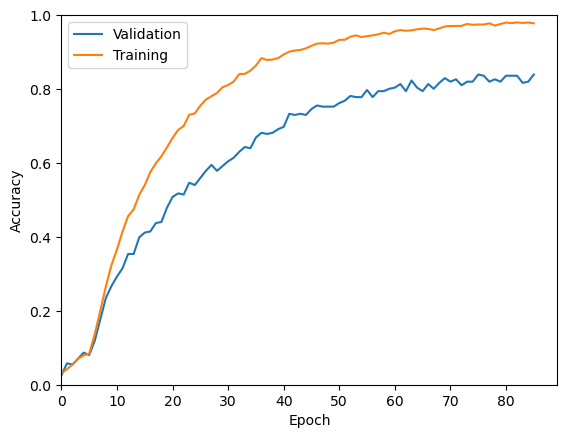

In [28]:
plt.plot(val_acc, label='Validation')
plt.plot(train_acc, label='Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(0, None)
plt.legend();

## Use the model

We load the model from the checkpoint and use it on the validation set to comparet hyena images.

In [ ]:
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True,
    num_classes=n_classes
)
checkpoint = torch.load('../data/tf_efficientnetv2_s.in21k_ft_in1k_viewpoint_finetune.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

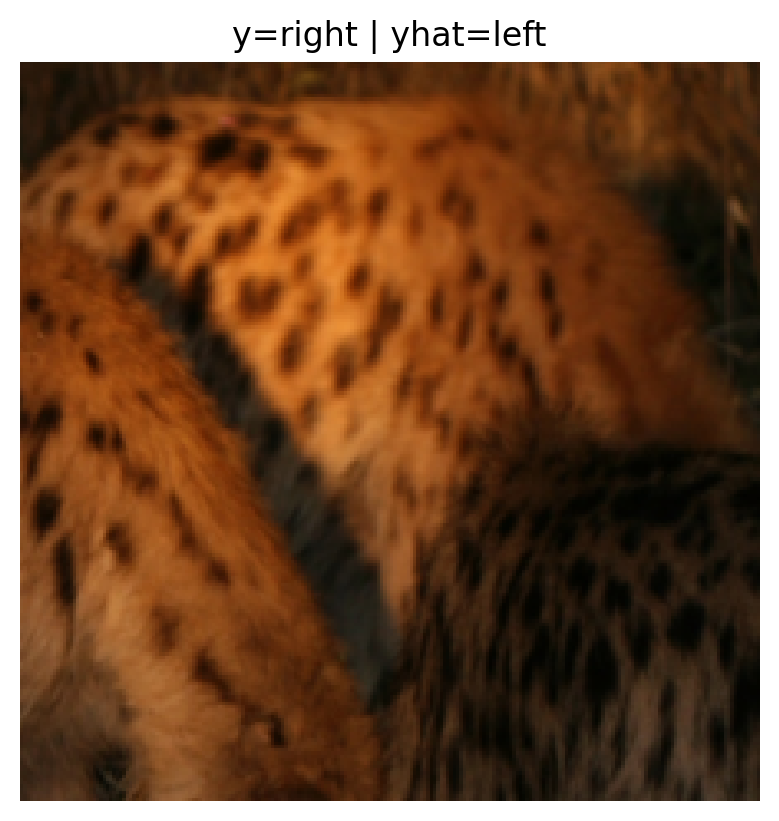

In [ ]:
val_iter = iter(val_ds)
next(val_iter);next(val_iter);next(val_iter);next(val_iter)
img, lbl = next(val_iter)
logits = model(img.unsqueeze(0).to(device))
prediction = logits.argmax(dim=1).item()
plt.imshow(unnormalize(img).permute(1, 2, 0).numpy())
plt.axis('off')
plt.title(f'y={int2view[lbl]} | yhat={int2view[prediction]}');